Classes found: ['Diseased', 'Dried', 'Healthy']

Sample entries:
                                                path     class  height  width
0  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
1  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
2  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
3  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112
4  /kaggle/input/betel-leaf-dataset/Controlled En...  Diseased    6112   6112

Class distribution:
class
Dried       340
Healthy     333
Diseased    220
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


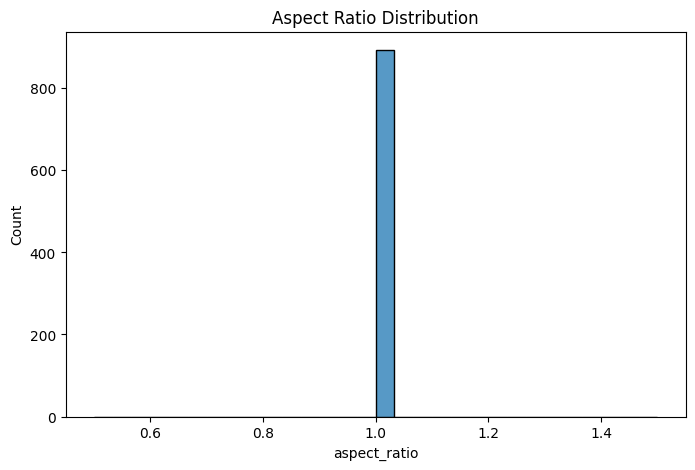

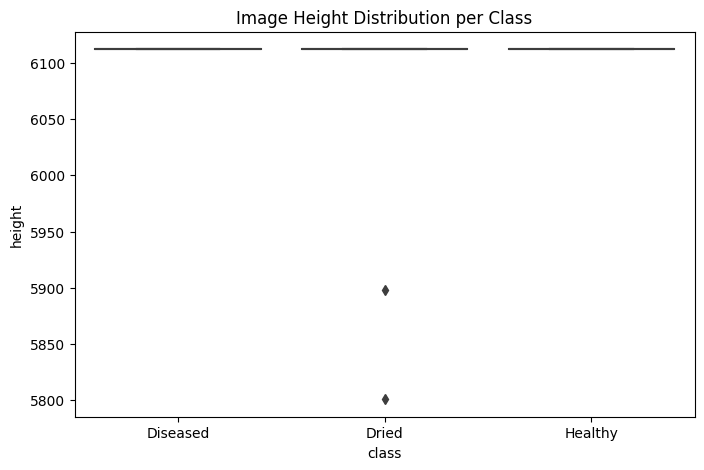

Computing RGB/HSV stats: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]



RGB/HSV mean/std summary:
           R_mean      R_std      G_mean      G_std      B_mean      B_std  \
count   20.000000  20.000000   20.000000  20.000000   20.000000  20.000000   
mean   158.223602  60.500712  166.787008  37.458642  163.011909  41.771130   
std      8.296913   7.185983    7.285863  11.869491    7.006443   8.167971   
min    142.968054  43.435114  145.645051  17.860924  145.667454  24.750282   
25%    153.833568  56.442079  163.837845  29.761833  159.615000  39.147868   
50%    158.466304  60.596207  167.415784  34.063269  162.417403  40.962408   
75%    160.476589  64.240123  172.632145  46.514551  166.925191  46.126167   
max    173.622374  73.600806  176.920709  59.265041  174.220334  56.912105   

           H_mean     S_mean      V_mean  
count   20.000000  20.000000   20.000000  
mean    93.792637  35.354346  170.203615  
std      6.839521   9.252077    6.698205  
min     74.255337  17.503272  150.926033  
25%     91.032063  30.047899  165.949832  
50%     95.4

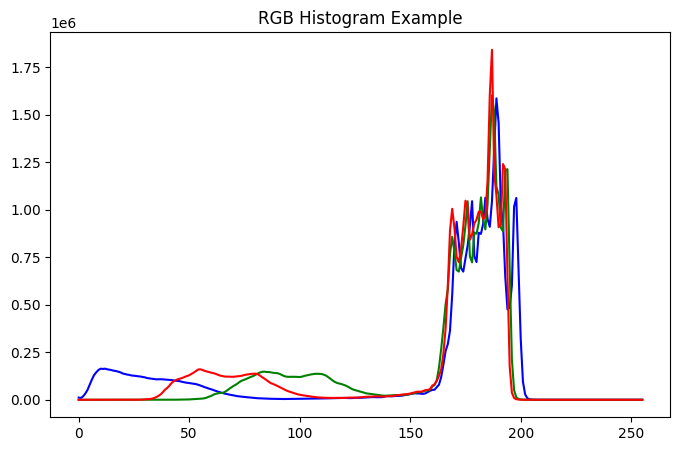

Brightness/Contrast: 100%|██████████| 20/20 [00:12<00:00,  1.56it/s]



Brightness mean/std (subset): [164.65112204  41.22281756]


Sharpness: 100%|██████████| 893/893 [11:13<00:00,  1.33it/s]


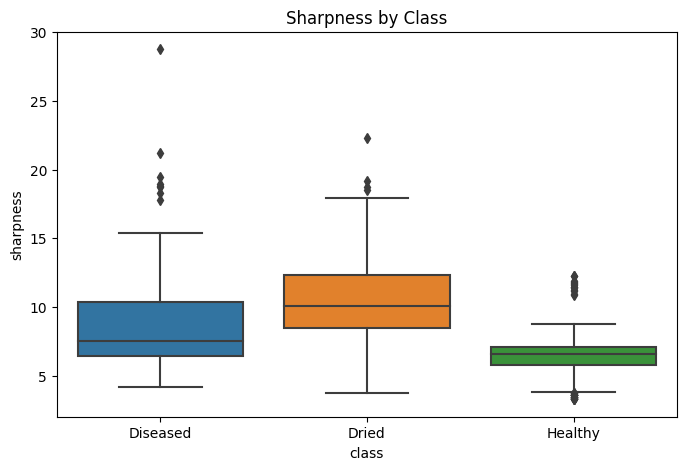

Gray-World Check: 100%|██████████| 20/20 [00:32<00:00,  1.62s/it]



Channel means (BGR): [158.22360172 166.78700776 163.01190929]


Checking duplicates: 100%|██████████| 893/893 [08:04<00:00,  1.84it/s]


Found 3 potential duplicates.
Duplicate pair: ('/kaggle/input/betel-leaf-dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_040.jpg', '/kaggle/input/betel-leaf-dataset/Controlled Environment/Diseased/CE_Diseased_Leaf_058.jpg')
Duplicate pair: ('/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_294.jpg', '/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_293.jpg')
Duplicate pair: ('/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_250.jpg', '/kaggle/input/betel-leaf-dataset/Controlled Environment/Healthy/CE_Healthy_Leaf_330.jpg')


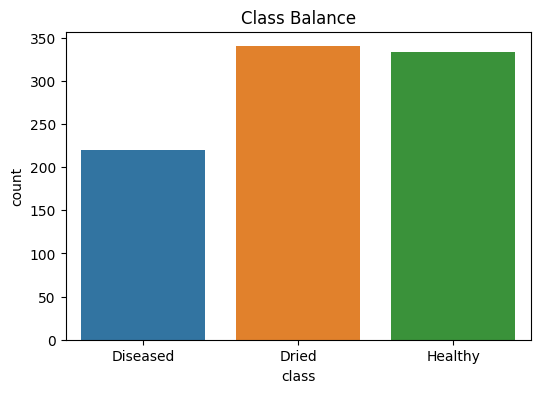


Train: 714 | Test: 179


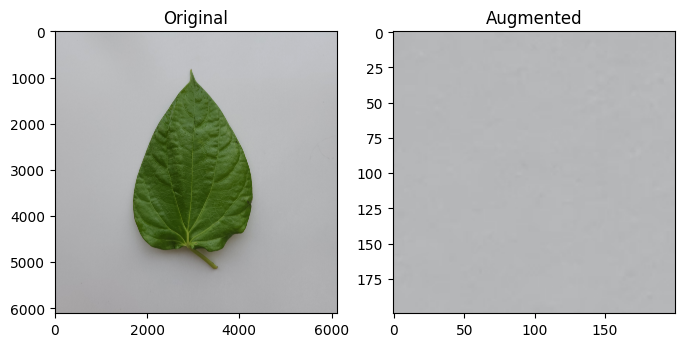

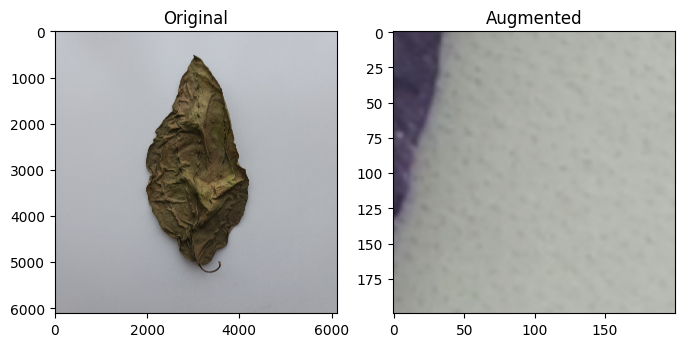

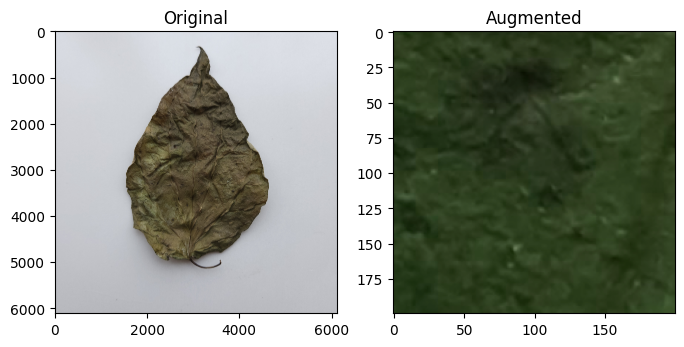


✅ EDA complete — all key outputs displayed.


In [1]:
# ===============================
# CSE475 (Fall 2025) - Task 1: EDA
# Dataset: Betel Leaf Dataset (btdym2t6mt/1)
# Author: <Your Name>
# ===============================

import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from PIL import Image
import imagehash
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ---- CONFIG ----
base_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"  # change if different
classes = os.listdir(base_path)
print("Classes found:", classes)

# ===============================
# 1. Load basic dataset info
# ===============================
data = []
for cls in classes:
    folder = os.path.join(base_path, cls)
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        img = cv2.imread(path)
        if img is not None:
            h, w, c = img.shape
            data.append([path, cls, h, w])

df = pd.DataFrame(data, columns=["path", "class", "height", "width"])
print("\nSample entries:")
print(df.head())
print("\nClass distribution:")
print(df["class"].value_counts())

# ===============================
# 2. Resolution and Aspect Ratio
# ===============================
df["aspect_ratio"] = df["width"] / df["height"]
plt.figure(figsize=(8,5))
sns.histplot(df["aspect_ratio"], bins=30)
plt.title("Aspect Ratio Distribution")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="height", data=df)
plt.title("Image Height Distribution per Class")
plt.show()

# ===============================
# 3. RGB & HSV Statistics
# ===============================
def color_stats(img):
    stats = {}
    for i, ch in enumerate(["R","G","B"]):
        stats[ch+"_mean"] = np.mean(img[:,:,i])
        stats[ch+"_std"] = np.std(img[:,:,i])
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    stats["H_mean"] = np.mean(hsv[:,:,0])
    stats["S_mean"] = np.mean(hsv[:,:,1])
    stats["V_mean"] = np.mean(hsv[:,:,2])
    return stats

subset = df.sample(20, random_state=42)
rgb_stats = []
for p in tqdm(subset["path"], desc="Computing RGB/HSV stats"):
    img = cv2.imread(p)
    rgb_stats.append(color_stats(img))
rgb_df = pd.DataFrame(rgb_stats)
print("\nRGB/HSV mean/std summary:")
print(rgb_df.describe())

# Plot RGB hist for one random sample
sample_img = cv2.imread(subset.iloc[0]["path"])
colors = ('b','g','r')
plt.figure(figsize=(8,5))
for i,col in enumerate(colors):
    histr = cv2.calcHist([sample_img],[i],None,[256],[0,256])
    plt.plot(histr, color=col)
plt.title("RGB Histogram Example")
plt.show()

# ===============================
# 4. Brightness/Contrast Spread
# ===============================
def brightness_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray.mean(), gray.std()

br_ct = []
for p in tqdm(subset["path"], desc="Brightness/Contrast"):
    img = cv2.imread(p)
    br_ct.append(brightness_contrast(img))
br_ct = np.array(br_ct)
print("\nBrightness mean/std (subset):", br_ct.mean(axis=0))

# ===============================
# 5. Sharpness/Noise Proxy (Laplacian)
# ===============================
def sharpness(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

df["sharpness"] = [sharpness(cv2.imread(p)) for p in tqdm(df["path"], desc="Sharpness")]
plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="sharpness", data=df)
plt.title("Sharpness by Class")
plt.show()

# ===============================
# 6. White Balance (Gray-World)
# ===============================
means = []
for p in tqdm(subset["path"], desc="Gray-World Check"):
    img = cv2.imread(p)
    means.append(np.mean(img, axis=(0,1)))
means = np.array(means)
print("\nChannel means (BGR):", means.mean(axis=0))

# ===============================
# 7. Duplicate Detection (Perceptual Hash)
# ===============================
hashes = {}
dupes = []
for p in tqdm(df["path"], desc="Checking duplicates"):
    try:
        h = imagehash.phash(Image.open(p))
        if h in hashes:
            dupes.append((p, hashes[h]))
        else:
            hashes[h] = p
    except:
        pass

print(f"\nFound {len(dupes)} potential duplicates.")
if dupes:
    for d in dupes[:5]:
        print("Duplicate pair:", d)

# ===============================
# 8. Class Balance Plot
# ===============================
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Class Balance")
plt.show()

# ===============================
# 9. Train-Test Split (Leakage Safeguard)
# ===============================
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["class"], random_state=42)
print(f"\nTrain: {len(train_df)} | Test: {len(test_df)}")

# ===============================
# 10. Augmentation Probe
# ===============================
transform = A.Compose([
    A.RandomCrop(height=200, width=200),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.GaussianBlur(p=0.3),
    ToTensorV2()
])

sample_paths = list(subset["path"].values)[:3]
for p in sample_paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    augmented = transform(image=img)["image"].permute(1,2,0).numpy()
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,2,2); plt.imshow(augmented); plt.title("Augmented")
    plt.show()

print("\n✅ EDA complete — all key outputs displayed.")


Checking Healthy: 100%|██████████| 333/333 [02:21<00:00,  2.35it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



📏 Image size summary:
             width       height
count   893.000000   893.000000
mean   6111.412094  6111.412094
std      12.626417    12.626417
min    5801.000000  5801.000000
25%    6112.000000  6112.000000
50%    6112.000000  6112.000000
75%    6112.000000  6112.000000
max    6112.000000  6112.000000


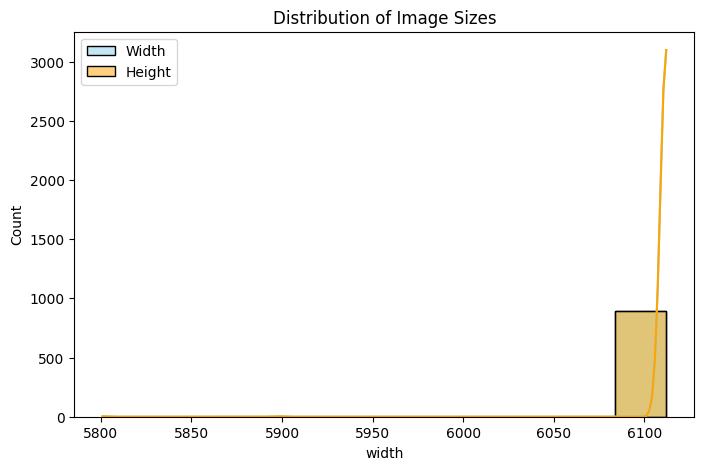

In [2]:
import os, cv2, pandas as pd
from tqdm import tqdm

# 🔹 Path to your dataset folder
# (In Kaggle, this is usually /kaggle/input/<dataset-folder-name>)
dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"

sizes = []
for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    for f in tqdm(os.listdir(cls_path), desc=f"Checking {cls}"):
        img_path = os.path.join(cls_path, f)
        img = cv2.imread(img_path)
        if img is not None:
            h, w, c = img.shape
            sizes.append([cls, w, h])

df = pd.DataFrame(sizes, columns=["class", "width", "height"])

print("\n📏 Image size summary:")
print(df.describe())

# Optional: visualize distribution
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.histplot(df["width"], color="skyblue", label="Width", kde=True)
sns.histplot(df["height"], color="orange", label="Height", kde=True)
plt.legend(); plt.title("Distribution of Image Sizes")
plt.show()


In [3]:
import os, cv2
from tqdm import tqdm

# Use same path you used in EDA
dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"  # 👈 তোমার dataset folder

resize_size = (224, 224)  # change if needed (128,128 for faster training)

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    for f in tqdm(os.listdir(cls_path), desc=f"Resizing {cls}"):
        img_path = os.path.join(cls_path, f)
        img = cv2.imread(img_path)
        if img is not None:
            resized = cv2.resize(img, resize_size)
            cv2.imwrite(img_path, resized)  # overwrite existing file

print("\n✅ All images resized directly in the same folder!")


Resizing Healthy: 100%|██████████| 333/333 [02:37<00:00,  2.11it/s]


✅ All images resized directly in the same folder!


In [4]:
import os, pandas as pd
from pathlib import Path

dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"
classes = sorted(os.listdir(dataset_path))  # ['Diseased', 'Dried', 'Healthy']

data = []
for cls in classes:
    cls_path = Path(dataset_path) / cls
    for f in os.listdir(cls_path):
        data.append({"path": str(cls_path / f), "class": cls, "sample_id": f.split("_")[0]})

df = pd.DataFrame(data)
print("Classes:", classes, "| Total images:", len(df))
df.head()


Classes: ['Diseased', 'Dried', 'Healthy'] | Total images: 893


,path,class,sample_id
0,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
1,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
2,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
3,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE
4,/kaggle/input/betel-leaf-dataset/Controlled En...,Diseased,CE


Classes: ['Diseased', 'Dried', 'Healthy'] | Total images: 893

===== SPLIT 90_9 (90:10) =====


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


Epoch 001: tr_loss=0.7091 val_loss=0.3842 val_acc=0.9012
Epoch 002: tr_loss=0.4024 val_loss=0.2871 val_acc=0.9259
Epoch 003: tr_loss=0.3667 val_loss=0.2743 val_acc=0.8765
Epoch 004: tr_loss=0.3033 val_loss=0.1933 val_acc=0.9630
Epoch 005: tr_loss=0.2633 val_loss=0.1905 val_acc=0.9259
Test Acc=0.9556, Time=61.6 min


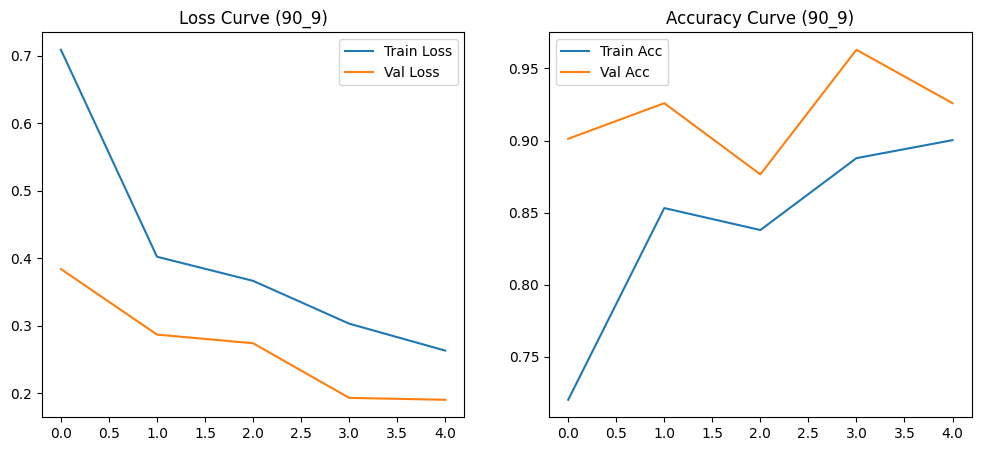

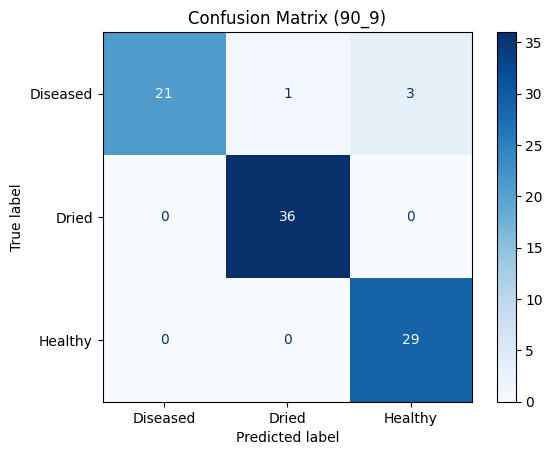

              precision    recall  f1-score   support

    Diseased       1.00      0.84      0.91        25
       Dried       0.97      1.00      0.99        36
     Healthy       0.91      1.00      0.95        29

    accuracy                           0.96        90
   macro avg       0.96      0.95      0.95        90
weighted avg       0.96      0.96      0.95        90


===== SPLIT 80_19 (80:20) =====
Epoch 001: tr_loss=0.6727 val_loss=0.4241 val_acc=0.7778
Epoch 002: tr_loss=0.3974 val_loss=0.4625 val_acc=0.7222
Epoch 003: tr_loss=0.2980 val_loss=0.2909 val_acc=0.9028
Epoch 004: tr_loss=0.3834 val_loss=0.3483 val_acc=0.8333
Epoch 005: tr_loss=0.2871 val_loss=0.2406 val_acc=0.8750
Test Acc=0.9274, Time=42.3 min


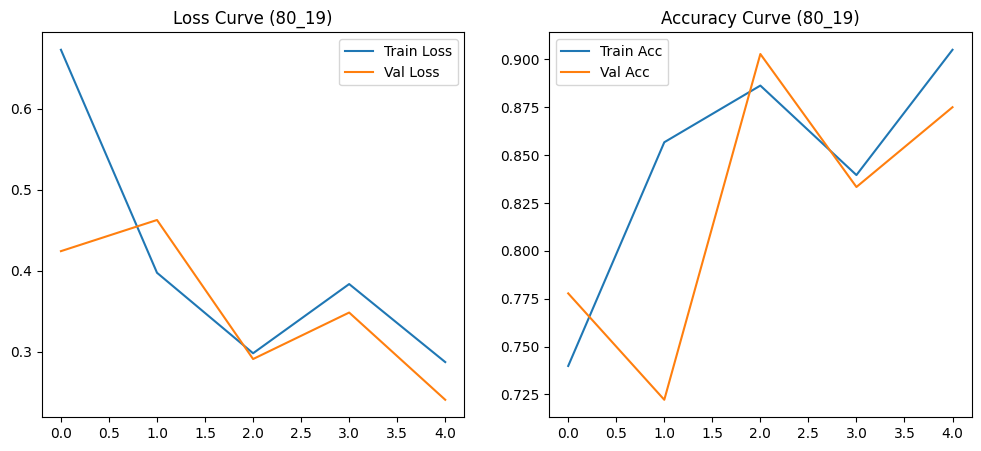

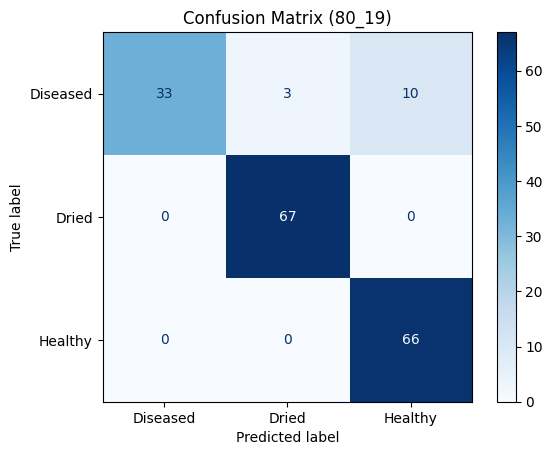

              precision    recall  f1-score   support

    Diseased       1.00      0.72      0.84        46
       Dried       0.96      1.00      0.98        67
     Healthy       0.87      1.00      0.93        66

    accuracy                           0.93       179
   macro avg       0.94      0.91      0.91       179
weighted avg       0.94      0.93      0.92       179


===== SPLIT 70_30 (70:30) =====
Epoch 001: tr_loss=0.6640 val_loss=0.5572 val_acc=0.7302
Epoch 002: tr_loss=0.4387 val_loss=0.3284 val_acc=0.8254
Epoch 003: tr_loss=0.3366 val_loss=0.2346 val_acc=0.9841
Epoch 004: tr_loss=0.3019 val_loss=0.2166 val_acc=0.9683
Epoch 005: tr_loss=0.2587 val_loss=0.1990 val_acc=0.9524
Test Acc=0.9366, Time=44.0 min


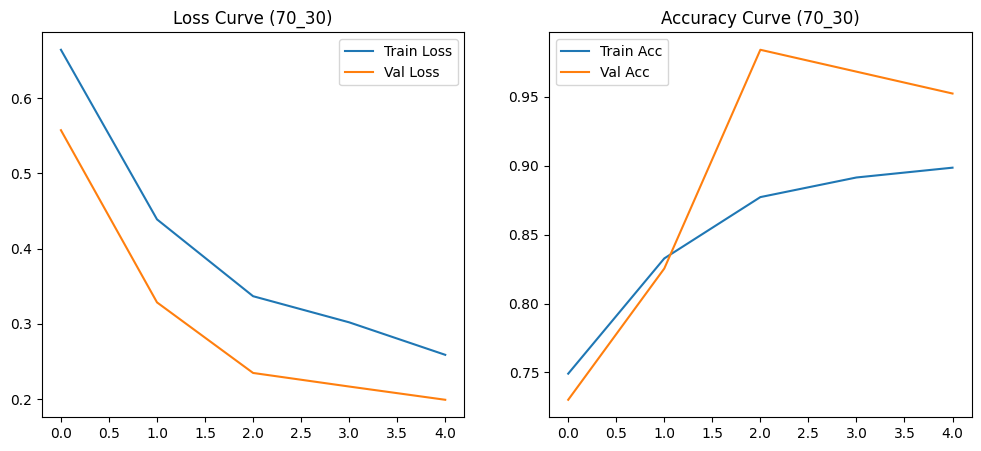

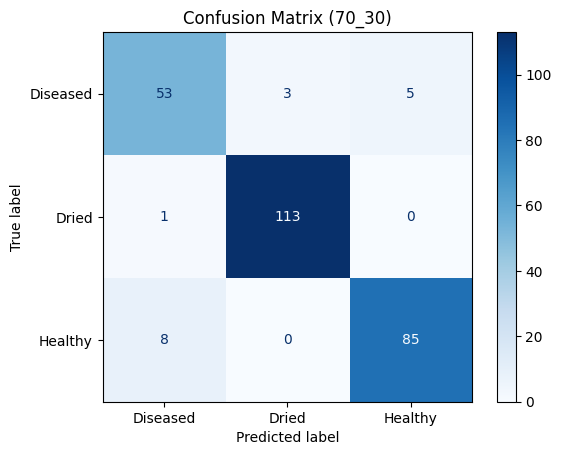

              precision    recall  f1-score   support

    Diseased       0.85      0.87      0.86        61
       Dried       0.97      0.99      0.98       114
     Healthy       0.94      0.91      0.93        93

    accuracy                           0.94       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.94      0.94      0.94       268


===== SPLIT 60_40 (60:40) =====
Epoch 001: tr_loss=0.7456 val_loss=0.5605 val_acc=0.6852
Epoch 002: tr_loss=0.4524 val_loss=0.3391 val_acc=0.9444
Epoch 003: tr_loss=0.3825 val_loss=0.3874 val_acc=0.8148
Epoch 004: tr_loss=0.3396 val_loss=0.2777 val_acc=0.8889
Epoch 005: tr_loss=0.2923 val_loss=0.2361 val_acc=0.9259
Test Acc=0.9330, Time=36.1 min


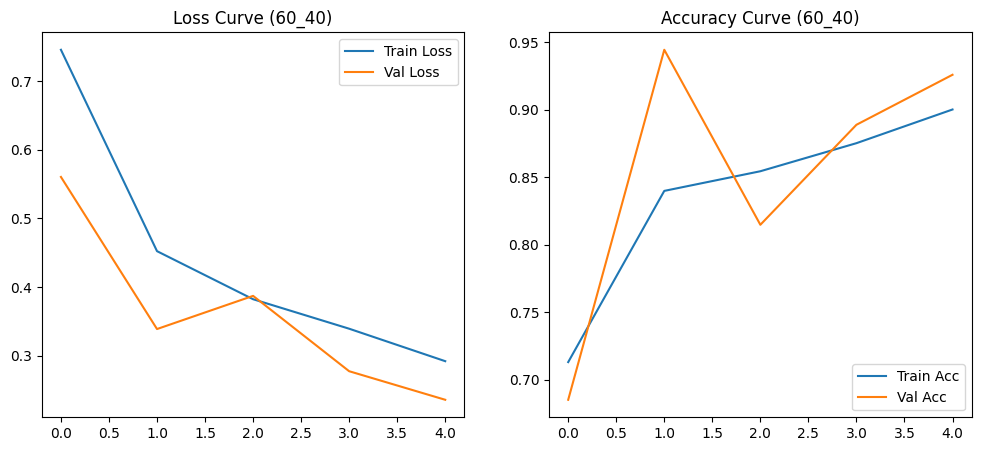

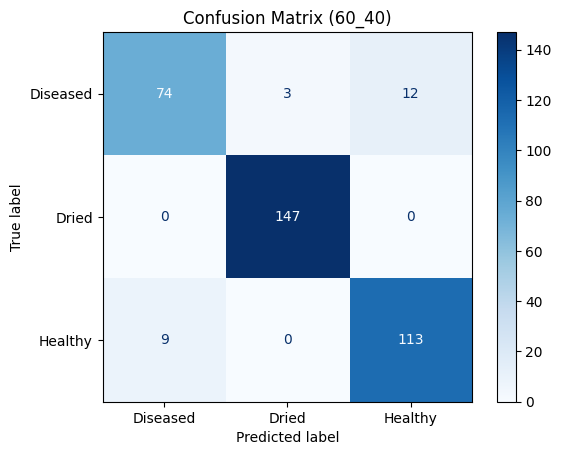

              precision    recall  f1-score   support

    Diseased       0.89      0.83      0.86        89
       Dried       0.98      1.00      0.99       147
     Healthy       0.90      0.93      0.91       122

    accuracy                           0.93       358
   macro avg       0.93      0.92      0.92       358
weighted avg       0.93      0.93      0.93       358


===== SPLIT 50_50 (50:50) =====
Epoch 001: tr_loss=0.7602 val_loss=1.1656 val_acc=0.3556
Epoch 002: tr_loss=0.6359 val_loss=0.4095 val_acc=0.8444
Epoch 003: tr_loss=0.4163 val_loss=0.3888 val_acc=0.8444
Epoch 004: tr_loss=0.3809 val_loss=0.3291 val_acc=0.8667
Epoch 005: tr_loss=0.4165 val_loss=0.2995 val_acc=0.8889
Test Acc=0.8881, Time=31.0 min


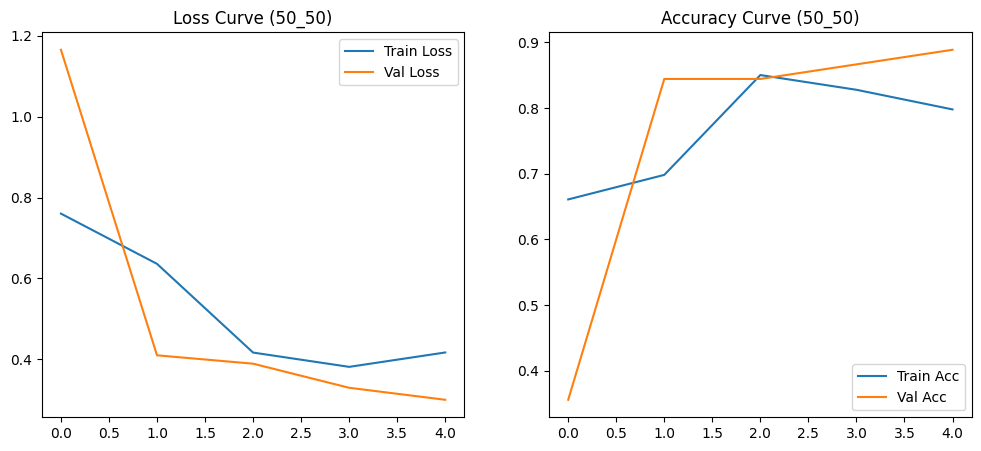

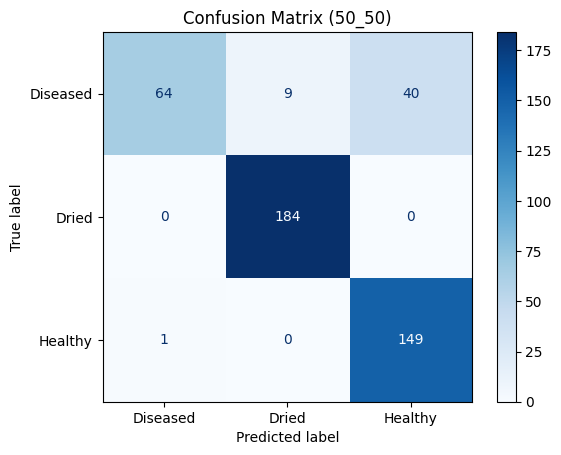

              precision    recall  f1-score   support

    Diseased       0.98      0.57      0.72       113
       Dried       0.95      1.00      0.98       184
     Healthy       0.79      0.99      0.88       150

    accuracy                           0.89       447
   macro avg       0.91      0.85      0.86       447
weighted avg       0.91      0.89      0.88       447


===== SPLIT 40_60 (40:60) =====
Epoch 001: tr_loss=0.8139 val_loss=0.6702 val_acc=0.8056
Epoch 002: tr_loss=0.5255 val_loss=0.5286 val_acc=0.8333
Epoch 003: tr_loss=0.4507 val_loss=0.4927 val_acc=0.6944
Epoch 004: tr_loss=0.4807 val_loss=0.3379 val_acc=0.8333
Epoch 005: tr_loss=0.4180 val_loss=0.3181 val_acc=0.8611
Test Acc=0.9011, Time=25.4 min


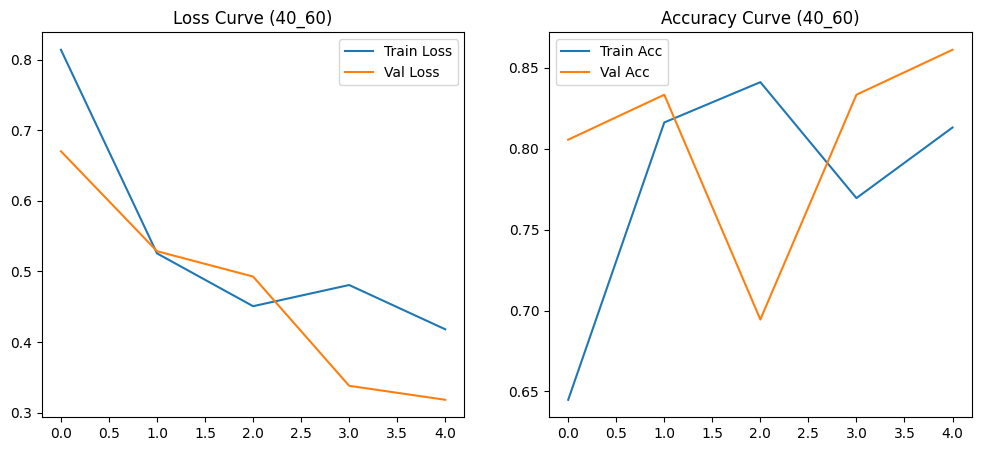

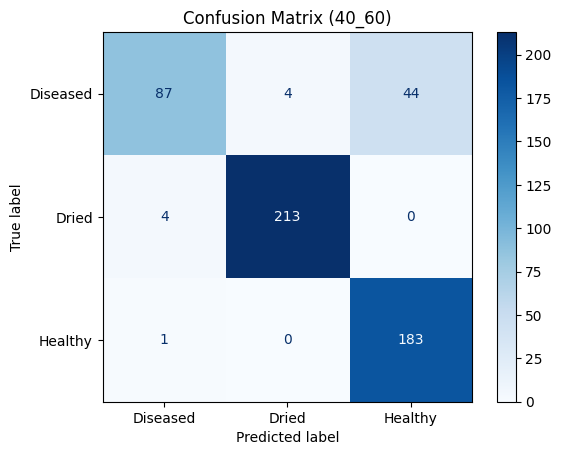

              precision    recall  f1-score   support

    Diseased       0.95      0.64      0.77       135
       Dried       0.98      0.98      0.98       217
     Healthy       0.81      0.99      0.89       184

    accuracy                           0.90       536
   macro avg       0.91      0.87      0.88       536
weighted avg       0.91      0.90      0.90       536


===== SPLIT 30_70 (30:70) =====
Epoch 001: tr_loss=0.8690 val_loss=0.7487 val_acc=0.7778
Epoch 002: tr_loss=0.5374 val_loss=0.5270 val_acc=0.7778
Epoch 003: tr_loss=0.4552 val_loss=0.4421 val_acc=0.8889
Epoch 004: tr_loss=0.3940 val_loss=0.3268 val_acc=0.9259
Epoch 005: tr_loss=0.3576 val_loss=0.3244 val_acc=0.9630
Test Acc=0.8706, Time=19.2 min


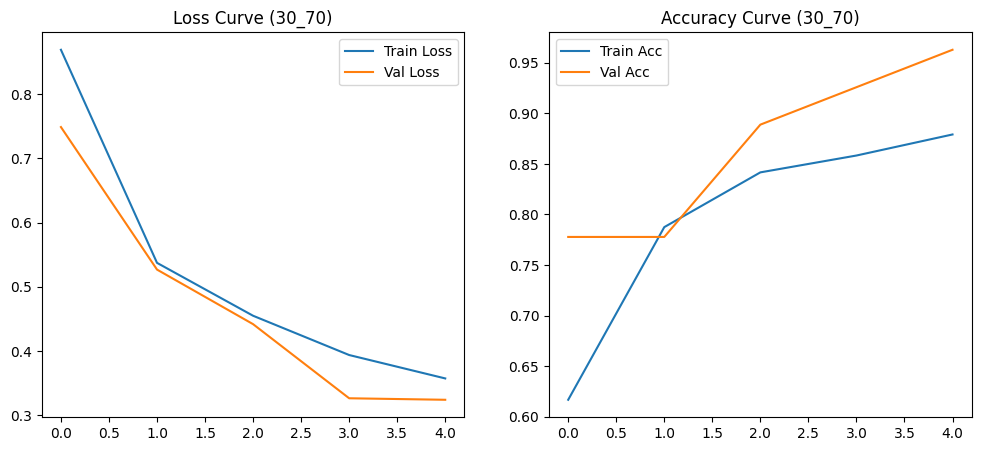

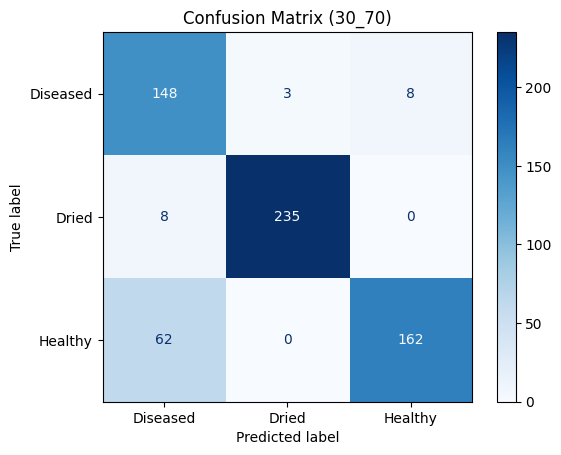

              precision    recall  f1-score   support

    Diseased       0.68      0.93      0.79       159
       Dried       0.99      0.97      0.98       243
     Healthy       0.95      0.72      0.82       224

    accuracy                           0.87       626
   macro avg       0.87      0.87      0.86       626
weighted avg       0.90      0.87      0.87       626


===== SPLIT 20_80 (20:80) =====
Epoch 001: tr_loss=1.0007 val_loss=1.1645 val_acc=0.4444
Epoch 002: tr_loss=0.7241 val_loss=0.9854 val_acc=0.4444
Epoch 003: tr_loss=0.5785 val_loss=0.7058 val_acc=0.5000
Epoch 004: tr_loss=0.4837 val_loss=0.4697 val_acc=0.8889
Epoch 005: tr_loss=0.3764 val_loss=0.5234 val_acc=0.6667
Test Acc=0.8168, Time=12.2 min


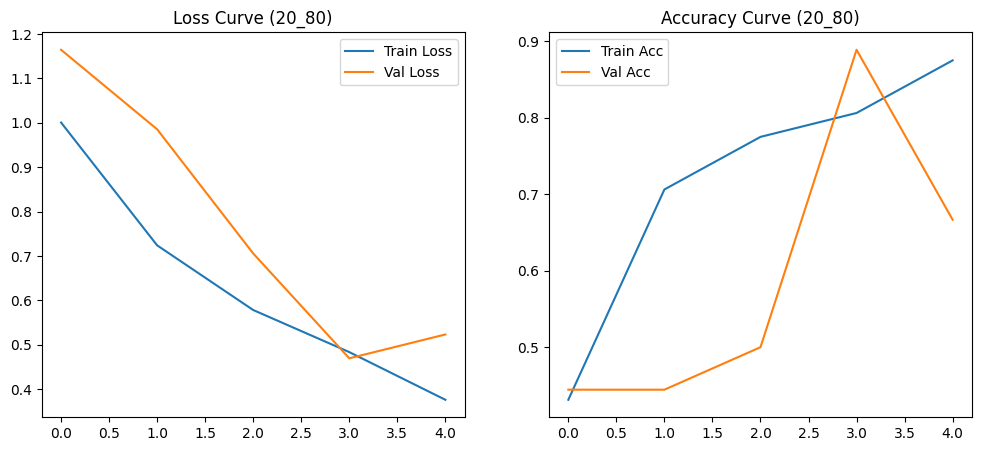

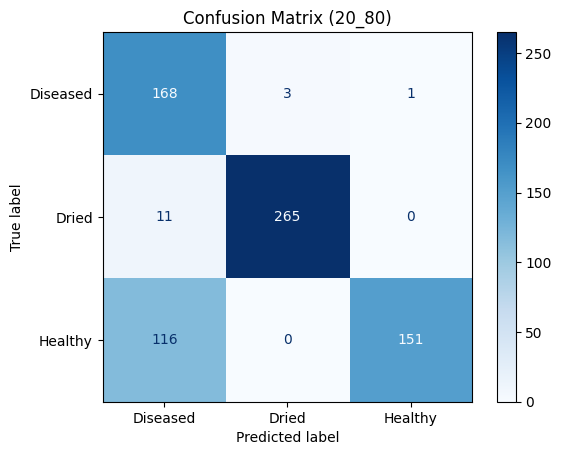

              precision    recall  f1-score   support

    Diseased       0.57      0.98      0.72       172
       Dried       0.99      0.96      0.97       276
     Healthy       0.99      0.57      0.72       267

    accuracy                           0.82       715
   macro avg       0.85      0.83      0.80       715
weighted avg       0.89      0.82      0.82       715


===== SPLIT 10_90 (10:90) =====
Epoch 001: tr_loss=1.1691 val_loss=0.9779 val_acc=0.3333
Epoch 002: tr_loss=0.9019 val_loss=0.8165 val_acc=0.6667
Epoch 003: tr_loss=0.7424 val_loss=0.7726 val_acc=0.7778
Epoch 004: tr_loss=0.5867 val_loss=0.5693 val_acc=0.8889
Epoch 005: tr_loss=0.5066 val_loss=0.6647 val_acc=0.6667
Test Acc=0.5858, Time=5.9 min


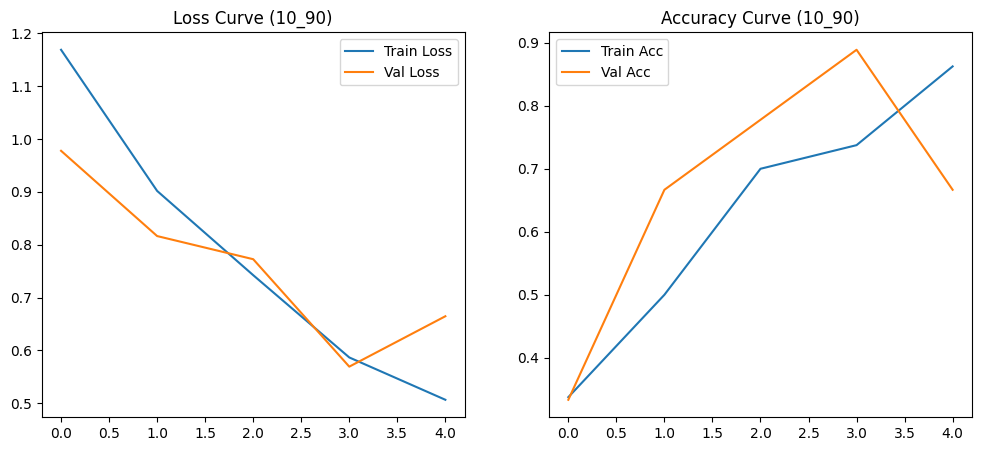

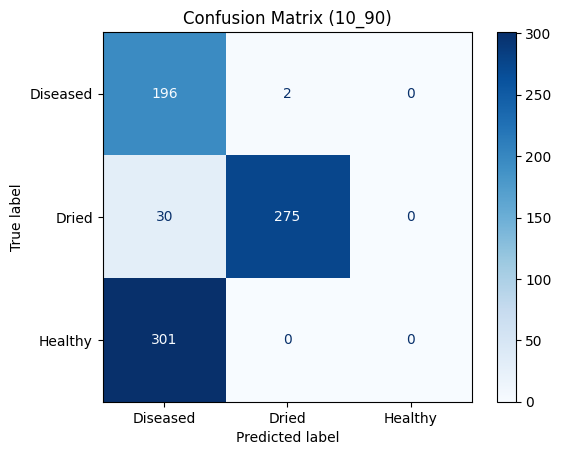

              precision    recall  f1-score   support

    Diseased       0.37      0.99      0.54       198
       Dried       0.99      0.90      0.95       305
     Healthy       0.00      0.00      0.00       301

    accuracy                           0.59       804
   macro avg       0.45      0.63      0.50       804
weighted avg       0.47      0.59      0.49       804


✅ All splits complete!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [5]:
# =====================================================
# CSE475 - Task 2 : Supervised Baseline (ResNet50)
# with automatic plots (loss/accuracy + confusion matrix)
# =====================================================
import os, time, json, random, numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt

# ================= SETTINGS =================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUT_DIR = Path("/kaggle/working/supervised_resnet50_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
EPOCHS = 5
BATCH_SIZE = 16
INPUT_SIZE = 224

# ================= CREATE DATAFRAME FROM EDA OUTPUT =================
dataset_path = "/kaggle/input/betel-leaf-dataset/Controlled Environment"
classes = sorted(os.listdir(dataset_path))  # ['Diseased', 'Dried', 'Healthy']

data = []
for cls in classes:
    cls_path = Path(dataset_path) / cls
    for f in os.listdir(cls_path):
        data.append({"path": str(cls_path / f), "class": cls, "sample_id": f.split("_")[0]})

df = pd.DataFrame(data)
num_classes = len(classes)
print("Classes:", classes, "| Total images:", len(df))
df.head()

# ================= DATASET =================
train_tfms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])
test_tfms = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor()
])

class LeafDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        path, label = self.df.loc[idx, ["path","class"]]
        img = plt.imread(path)
        if img.ndim==2: img = np.stack([img]*3, axis=-1)
        img = transforms.ToPILImage()(img)
        if self.transform: img = self.transform(img)
        label = classes.index(label)
        return img, label

# ================= MODEL + TRAIN/EVAL =================
def get_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for p in model.parameters(): p.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(DEVICE)

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct = 0,0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += (out.argmax(1)==labels).sum().item()
    return running_loss/len(loader.dataset), correct/len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0,0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item()*imgs.size(0)
            correct += (out.argmax(1)==labels).sum().item()
            all_preds += out.softmax(1).cpu().tolist()
            all_labels += labels.cpu().tolist()
    return (running_loss/len(loader.dataset),
            correct/len(loader.dataset),
            np.array(all_preds),
            np.array(all_labels))

# ================= SPLITS + TRAIN LOOP =================
ratios = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
ckpt_file = OUT_DIR / "checkpoint.json"
done_splits = json.load(open(ckpt_file)) if ckpt_file.exists() else []

for r in ratios:
    split_name = f"{int(r*100)}_{int((1-r)*100)}"
    if split_name in done_splits:
        print(f"Skipping {split_name}, already done.")
        continue

    print(f"\n===== SPLIT {split_name} ({r*100:.0f}:{(1-r)*100:.0f}) =====")

    # Train/test split
    if df["sample_id"].nunique() < 2:
        tr_idx, te_idx = train_test_split(np.arange(len(df)), train_size=r, random_state=SEED, shuffle=True)
    else:
        gss = GroupShuffleSplit(n_splits=1, train_size=r, random_state=SEED)
        tr_idx, te_idx = next(gss.split(df, groups=df["sample_id"]))
    df_trfull, df_te = df.iloc[tr_idx], df.iloc[te_idx]

    # Validation split (10% of train)
    if df_trfull["sample_id"].nunique()<2:
        tr2_idx, va2_idx = train_test_split(np.arange(len(df_trfull)), train_size=0.9, random_state=SEED, shuffle=True)
    else:
        gss2 = GroupShuffleSplit(n_splits=1, train_size=0.9, random_state=SEED)
        tr2_idx, va2_idx = next(gss2.split(df_trfull, groups=df_trfull["sample_id"]))
    df_tr, df_va = df_trfull.iloc[tr2_idx], df_trfull.iloc[va2_idx]

    # Datasets + Dataloaders
    train_ds, val_ds, test_ds = LeafDataset(df_tr, train_tfms), LeafDataset(df_va, test_tfms), LeafDataset(df_te, test_tfms)
    train_dl, val_dl, test_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True), DataLoader(val_ds, BATCH_SIZE, shuffle=False), DataLoader(test_ds, BATCH_SIZE, shuffle=False)

    # Model, criterion, optimizer
    model = get_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

    # Train
    history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
    start = time.time()
    for epoch in range(1, EPOCHS+1):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, criterion, optimizer)
        va_loss, va_acc, _, _ = evaluate(model, val_dl, criterion)
        print(f"Epoch {epoch:03d}: tr_loss={tr_loss:.4f} val_loss={va_loss:.4f} val_acc={va_acc:.4f}")
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)

    duration = time.time()-start

    # Test evaluation
    te_loss, te_acc, te_preds, te_labels = evaluate(model, test_dl, criterion)
    print(f"Test Acc={te_acc:.4f}, Time={duration/60:.1f} min")

    # ================= PLOTS =================
    # Loss + Accuracy curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"Loss Curve ({split_name})")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"Accuracy Curve ({split_name})")
    plt.legend()
    plt.show()

    # Confusion Matrix
    y_pred_labels = te_preds.argmax(1)
    cm = confusion_matrix(te_labels, y_pred_labels, labels=range(num_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix ({split_name})")
    plt.show()

    # Classification report
    print(classification_report(te_labels, y_pred_labels, target_names=classes))

    # Save outputs
    split_dir = OUT_DIR / f"split_{split_name}"
    split_dir.mkdir(exist_ok=True)
    torch.save(model.state_dict(), split_dir / "model.pt")
    pd.DataFrame(history).to_csv(split_dir / "history.csv", index=False)
    np.savez(split_dir / "preds_labels.npz", preds=te_preds, labels=te_labels)

    # Update checkpoint
    done_splits.append(split_name)
    json.dump(done_splits, open(ckpt_file,"w"))

    # Free GPU memory
    del model, optimizer, train_dl, val_dl, test_dl
    torch.cuda.empty_cache()

print("\n✅ All splits complete!")
